In [ ]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import sympy as sp
from scipy.integrate import odeint
from scipy.optimize import fsolve


In [ ]:
def f( x, alpha):

    """
    Define the conformity function. 
    x = dependent variable, proportion of people favoring X in whole group 
    alpha = shape parameter. 
    alpha >1 -> s-shape
    alpha <1 -> inverse s-shape
    alpha = 1 -> linear
    """
    if (x>=0 and x<=0.5):
        
        y = ((2 * x)**alpha)/ 2
    elif (x>0.5 and x <=1):
        y =  1 - ((2 * (1 - x)) ** alpha) / 2
    else:
        y = 0
    return y



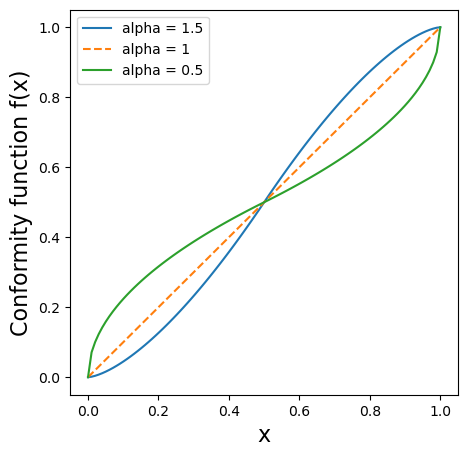

In [ ]:
#s,y = np.meshgrid(np.arange( 0, 1, stepsize), np.arange(-4, 4, stepsize))
#stepsize = 0.1

alpha = 1.5
m = 0.5

x = np.linspace(0,1,100)
#print(x)
f_a1 = np.zeros((len(x),1))
f_a15 = np.zeros((len(x),1))
f_a05 = np.zeros((len(x),1))
for num, iter in enumerate (x) :
    f_a1[num] = f( iter, 1)
    f_a15[num] = f( iter, 1.5)
    f_a05[num] = f( iter, 0.5)



fig = plt.figure(1, figsize= (5,5))
#plt.plot('xlabel', 'ylabel')#, data='a')

plt.plot(x, f_a15, '-', label='alpha = 1.5')
plt.plot(x, f_a1, '--', label='alpha = 1')
plt.plot(x, f_a05, '-', label='alpha = 0.5')  
plt.xlabel("x", fontsize=16)
plt.ylabel("Conformity function f(x)", fontsize=16)
plt.legend()


In [ ]:
def odeSys(var, t, para):
    """
    Define the system of ordinary differential equations 
    var = 2-column matrix, where the two columns are xi and xs, respectively. 
    xi = proportion of individual learners favor option X, 
    xs = proportion of social learners favor option X. 
    para = dictionary that stores the parameters of the system. 
    t = time array. 
    """
    xi, xs = var
    
    # compute proportion of total favoring option X. 
    x = (1 - para["s"]) * xi + para["s"]*xs
    
    # define the derivative dx_i/dt according to ODE
    dxi_dt = para["m"]*(1 - xi) - (1 - para["m"])*xi
    
    # define  transition rates of social learners 
    T_in = f(x, para["alpha"]) # transitioning from option Y into X 
    T_out = f((1 - x), para["alpha"])  # transitioning from X to Y. 
    
    # define derivative dx_s/dt according to ODE. 
    dxs_dt = T_in*(1-xs) - T_out*(xs)
    
    return [dxi_dt, dxs_dt]


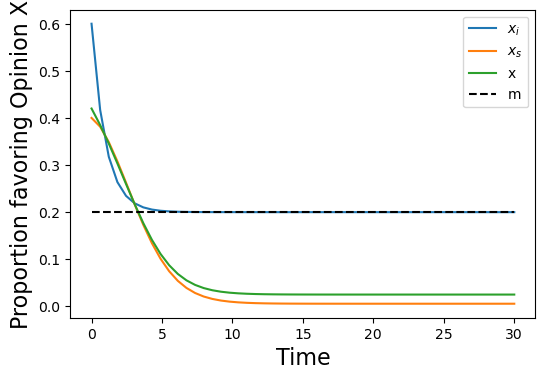

In [ ]:
var0 = [0.6, 0.4] # initial condition for [x_i, x_s]
para = {"s": 0.9, "m": 0.2, "alpha": 1.5}  # parameters of system. 
t = np.linspace(0, 30, 50) #  time 

var = odeint(odeSys, var0, t, args = (para,))  # run ode system 

# plot results 
xi = var[:,0]
xs = var[:, 1]
x = (1-para["s"])*xi + (para["s"])*xs

plt.figure(figsize = (6, 4))
plt.plot(t, xi) 
plt.plot(t, xs)
plt.plot(t, x )
plt.plot(t, para["m"]*np.ones(np.shape(t)), "k--")

plt.xlabel("Time",fontsize=16)
plt.ylabel("Proportion favoring Opinion X", fontsize=16)
plt.legend([r"$x_i$", "$x_s$", "x", "m"])


## fixed point and stabilty analysis

fixed point of individual learners $x_i$ will always be ${x_i}^* = m$, therefore in the following only the social leaners fixed points ${x_s}^* $ will be analysed. 

In [ ]:
def rhs_s_eq(xs, para):
    """
    Compute the right hand side of the x_s equation at the point x_i = m
    """
        
    x = (1 - para["s"])*para["m"]+ para["s"]*xs
    
    T_in = f(x, para["alpha"]) # transition rate from Y to X
    T_out = f(1.-x, para["alpha"]) # transition rate from X to Y 
    
    rhs = T_in*(1.-xs) - T_out*xs
    
    return rhs


def df_dx(x, para):
    """
    derivative of f function. Computed by hand. 
    """
    alpha = para["alpha"]
    
    if (x >0) and (x< 1): # the derivatiev for x between 0 and 1. 
        if x<= 0.5: 
            out = (0.5*(2*x)**alpha * alpha)/x
        elif x>0.5:
            out = ((2 - 2*x)**alpha * alpha)/(2 - 2*x)
        
    elif (x == 0) or (x == 1): 
        # at 0 or 1, the piecewise expression above has a dividing by 0 problem. 
        # but from taking the limit, we can see the derivative at both points for alpha > 1 is 0, 
        # and for alpha <1 infinity, and for alpha = 1 , 1. 
    
        if alpha > 1: 
            out = 0
        elif alpha < 1: 
            out = np.inf
        elif alpha == 1:
            out = 1
    else: 
        out = np.nan
        print("warning: x out of range")
    return out



def jacobian_eignvalues(x_i, x_s, para):
    """
    get the eigenvalues of the Jacobian of the dynamical system 
    and stability at the fixed point(x_i, x_s)
    calculated analytically, the jacobian matrix is: J = [[-1, 0], [f'(x)(1-s), f'(x)s -1]]
    where x = s x_s + (1-s) x_i. 
    """
    s = para["s"]
    x = s*x_s + (1-s)*x_i

    
    # compute the 3rd and 4th terms in the Jacobian matrix 
    J21 = df_dx(x, para)*(1-s)
    J22 = df_dx(x, para)*s - 1
    
    # construct Jacobian matrix
    J = np.array([[-1, 0], [J21, J22]])

    # compute eigenvalues
    lambdas, eigenvectors = np.linalg.eig(J)
    
    # determine convergence
    if len(lambdas) != 2:
        print("warning: did not return 2 eigen values")
        stab = np.nan
    elif (lambdas[0] <0) and (lambdas[1]< 0): # 2 negative eigenvalues -> fixed point stable. 
        stab = 1
    elif (lambdas[0] >0) or (lambdas[1] > 0):  # 1 positive eigenvalue -> fixed point unstable. 
        stab = 0
    else: 
        stab = np.nan
    
    return stab, lambdas

def get_branch(slist, xs0, para):
    """
    Get the fixed point for xs for one branch of the bifurcation diagram. 
    slist = a list of s values to compute the solution for 
    xs0 = initial value of xs
    para = parameters of the system. 
    """
    
    xs_sol = [] # List to store solution for fixed point of xs. 
    stab = [] # List to store the stability of the fixed points
    sout = [] # List to store the s values when in to the computation. 
    for s in slist: 
        para["s"] = s
        # solve for the when the rhs of xs equation is 0. 
        sol, blah, flag, blah2 = fsolve(rhs_s_eq, xs0, args=(para, ), xtol = 1e-8, full_output=1)
       
        if (flag == 1) and (sol >=0) and (sol<=1):  # check if fsolve converged and solution in range. 
            xs0 = sol[0] # update initial condition for numerical continuation
            xs_sol.append(sol[0]) # store solution 
            
            # determine stability
            stab1, lambdas = jacobian_eignvalues(para["m"], sol[0], para)
            
            stab.append(stab1) # store stability 
            
            sout.append(s) # store s values. 
            
        else: 
            break 
    return np.asarray(xs_sol), np.asarray(stab), np.asarray(sout)

def plotBranch(xs_sol, stab, sout, para): 
    """
    Plot 1 branch of the bifurcation diagram. 
    """
    # get index of the stable and unstable fixed points 
    stabIdx = (stab==1)
    unstabIdx = (stab==0)
      
    # find fixed points of x based on solution to xs. 
    xsol = (1 - sout)*para["m"] + sout*xs_sol

    plt.plot(sout[stabIdx], xsol[stabIdx], "b-")
    plt.plot(sout[unstabIdx], xsol[unstabIdx], "b--")

def numerical_cont(slist, para, xs0List):
    """
    Numerical continuation running multiple bifurcation branches with different starting conditions
    """
    for xs0 in xs0List:
        xs_sol, stab, sout = get_branch(slist, xs0, para)
        plotBranch(xs_sol, stab, sout, para)








(-0.05, 1.05)

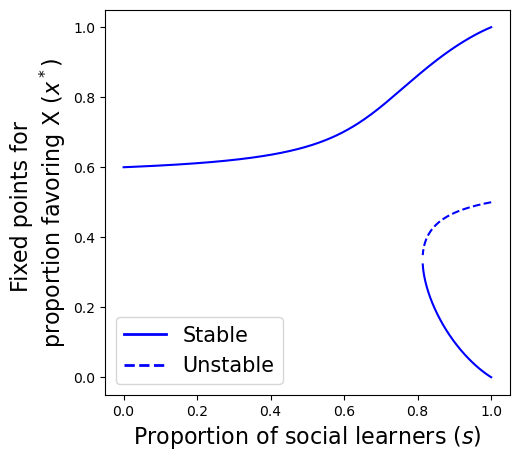

In [ ]:
"""
This is code for plotting the result from the core model by solving for fixed points and stability for the dynamical system.
"""
plt.figure(figsize = (24, 5))

"""
(A) Bifurcation diagram of x vs. r; Equal merit 
"""
plt.subplot(1, 4, 1)
para = {"s": np.nan, "m": 0.6, "alpha": 1.5}
slist = np.linspace(1, 0, 1000) # the direction of the plot is right to left, for continuation

xs0_List = [0, 0.5, 1]

numerical_cont(slist, para, xs0_List)

plt.xlabel("Proportion of social learners ($s$)",fontsize=16)
plt.ylabel("Fixed points for \nproportion favoring X ($x^*$)", fontsize=16)

# legend
blueLine = mlines.Line2D([], [],color='b', marker="None", linestyle='-',
                          linewidth=2, label='Stable')
blueDashLine = mlines.Line2D([], [],color='b', marker="None", linestyle='--',
                          linewidth=2, label= 'Unstable')
plt.legend(handles = [blueLine, blueDashLine], loc = 3, prop={'size': 15})
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])


(-0.05, 1.05)

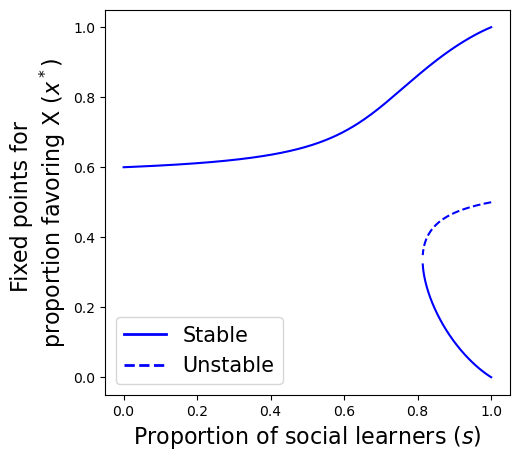

In [ ]:
"""
This is code for plotting the result from the core model by solving for fixed points and stability for the dynamical system.
"""
plt.figure(figsize = (24, 5))

"""
(B) Bifurcation diagram of x vs. r; Equal merit 
"""
plt.subplot(1, 4, 1)
para = {"s": np.nan, "m": 0.6, "alpha": 1.5}
slist = np.linspace(1, 0, 1000) # the direction of the plot is right to left, for continuation

xs0_List = [0, 0.5, 1]

numerical_cont(slist, para, xs0_List)

plt.xlabel("Proportion of social learners ($s$)",fontsize=16)
plt.ylabel("Fixed points for \nproportion favoring X ($x^*$)", fontsize=16)

# legend
blueLine = mlines.Line2D([], [],color='b', marker="None", linestyle='-',
                          linewidth=2, label='Stable')
blueDashLine = mlines.Line2D([], [],color='b', marker="None", linestyle='--',
                          linewidth=2, label= 'Unstable')
plt.legend(handles = [blueLine, blueDashLine], loc = 3, prop={'size': 15})
plt.ylim([-0.05, 1.05])
plt.xlim([-0.05, 1.05])

(0.5, 1.025)

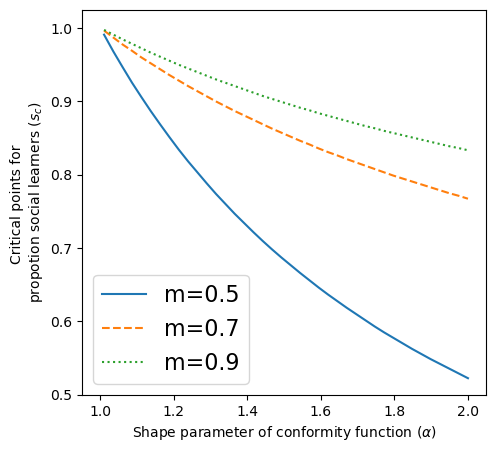

In [29]:
import copy

def get_rc(mlist, slist, alphalist):
    """
    Find the critical bifurcation point of the bifurcation diagrams. 
    mlist = a list of (a few) m values
    slist = a list of s values. 
    alphalist = a list of alpha values. (to be plotted on x-axis)
    
    """

    sstarlist = []
    # run 1 branch from v = 0, the last point should be where the stable and unstable meets. 
    # Note this only applies to m >= 0.5. 
    v0 = 0
    for m in mlist: 
        sstar = []
        for alpha in alphalist: 
            para = {"r": np.nan, "m": m, "alpha": alpha}
            # the value r here isn't useful... it gets over written by the next line. 
    
            vsol, stab, sout = get_branch(slist, v0, para)
            sstar.append(copy.deepcopy(sout[-1]))
        sstarlist.append(sstar)
    return sstartlist 

"""
Numerically solve for the bifurcation point 

"""
plt.figure(figsize = (24, 5))

slist = np.linspace(1, 0.5, 1000)
alphalist = np.linspace(1.01, 2, 40)

mlist = [0.501, 0.7, 0.9]
sstarlist = []

# run 1 branch from v = 0, the last point should be where the stable and unstable meets. 
# Note this only applies to m >= 0.5. 

v0 = 0
for m in mlist: 
    sstar = []
    for alpha in alphalist: 
        para = {"s": np.nan, "m": m, "alpha": alpha}
    
        vsol, stab, sout = get_branch(slist, v0, para)
        sstar.append(copy.deepcopy(sout[-1]))
    sstarlist.append(sstar)

#(C) #Critical r.

plt.subplot(1, 4, 3)
plt.plot(alphalist, sstarlist[0], "-")
plt.plot(alphalist, sstarlist[1], "--")
plt.plot(alphalist, sstarlist[2], ":")
plt.xlim([0.95, 2.05])
plt.xlabel(r"Shape parameter of conformity function ($\alpha$)")
plt.ylabel("Critical points for \n" + r"propotion social learners ($s_c$)")
plt.legend(["m=0.5", "m=0.7", "m=0.9"], loc = 3, prop={'size': 16})
plt.ylim([0.5, 1.025])

 # Simulate spectrum extension model ,
    
The transition rates between $X$ and $Y$ are: 

$P(Y  \rightarrow X) = (1-s_i) m + s_i f(x)$, 

$P(X  \rightarrow Y) =  (1-s_i) (1-m) + s_if(1-x)$

where $s_i$ is the degree to which a person is a social learner:

s = 0 -> purely individual learning

s = 1 -> purely social learning

In [30]:
def update_opinion(opinion, slist, m, alpha):
    N = len(opinion)          #number of total learners
    x = np.mean(opinion)/ N   #number of people of opinion X

    p_01 = (1 - slist) * m + slist * f(x)           #transition rates from 0 to 1 (Y to X)
    p_10 = (1 - slist)*(1 - m) + slist * f(1-x)     #transition rates from 1 to 0 (X to Y)

    IDx0 = (opinion == 0)   #iD of people with opinion 0
    IDx1 = (opinion == 1)   #iD of people with opinion 1

    rand = np.random.uniform(N)/10

    opinion[IDx0 & (rand < p_01)] = 1
    opinion[IDx1 & (rand < p_10)] = 0

    return opinion

def check_convergence( xlist, tol = 0.005, window= 30, min_length_path= 10):
    min_length = min_length_path + window
    if len(xlist) > min_length:
        L = len(xlist)
        index_window = L - window
        series = list[idxLeft:]
        xstd = np.std(series)
        if xstd < tol:
            convergence = 1
            avg = np.mean(series)
        else:
            convergence = 0
            average = np.nan

    else:
        xstd = np.nan
        convergence = 0
        avg = np.nan
    return convergence, avg, xstd
    
def run_till_convergence( opinion, slist, m, alpha, tmax):     
    xlist = []
    N = len(slist)
    x0 = np.mean(opinion)/N
    for t in range (tmax):
        x = np.mean(opinion)/N
        xlist.append(x)
        opinion = update_opinion(opinion, slist, m, alpha)
        conv, avg, xstd = check_convergence(xlist)
        if conv ==1:
            break
    return {"x_ss": avg, "x0": x0, "m": m, "alpha": alpha, "tConv":t}


        
        
    

    

    

    

# spatial


In [ ]:
# Define symbols
x_s, m, s, a = symbols('x_s m s a')

# Example values for m and s
m_val = para["m"]  # Example value for m
s_val = para["s"]  # Example value for s
a_val

# Define the equation




x = (1 - s) * xi + s * xs
    
    # define the derivative dx_i/dt according to ODE
dxi_dt = m *(1 - xi) - (1 - m) * xi
    
    # define  transition rates of social learners 
T_in = f(x, para["alpha"]) # transitioning from option Y into X 
T_out = f((1 - x), para["alpha"])  # transitioning from X to Y. 
    
    # define derivative dx_s/dt according to ODE. 
dxs_dt = T_in*(1-xs) - T_out*(xs)


equation = 1 - ((2 * (1 - (1 - s) * m + s * x_s)) ** a) / 2 - x_s

# List to store solutions
solutions = []

# Range for a, e.g., from 0 to 2, stepping by 0.1
a_values = [N(i/10) for i in range(21)]  # This creates a list of a values from 0 to 2 in steps of 0.1

for a_val in a_values:
    # Substitute m, s, and a into the equation
    equation_substituted = dxs_dt.subs({m: m_val, s: s_val, a: a_val})
    
    try:
        # Attempt to solve the equation numerically starting from an initial guess
        initial_guess = 0
        x_s_solution = nsolve(equation_substituted, x_s, initial_guess)
        solutions.append((a_val, x_s_solution))
    except Exception as e:
        print(f"Could not solve for a={a_val}: {e}")

# Print solutions
for a_val, solution in solutions:
    print(f"For a = {a_val}, the solution x_s is approximately {solution}")

TypeError: cannot determine truth value of Relational

In [ ]:
solutions[:]

[(0, 0.500000000000000),
 (0.100000000000000, 0.460168392938171),
 (0.200000000000000, 0.419810627366725),
 (0.300000000000000, 0.379374825273839),
 (0.400000000000000, 0.339301977282891),
 (0.500000000000000, 0.300000000000000),
 (0.600000000000000, 0.261822741803357),
 (0.700000000000000, 0.225056352967288),
 (0.800000000000000, 0.189913717787901),
 (0.900000000000000, 0.156536080405972),
 (1.00000000000000, 0.125000000000000),
 (1.10000000000000, 0.0953274525481220),
 (1.20000000000000, 0.0674971113720513),
 (1.30000000000000, 0.0414553387131669),
 (1.40000000000000, 0.0171259809473423),
 (1.50000000000000, -0.00558146004827892),
 (1.60000000000000, -0.0267653633723482),
 (1.70000000000000, -0.0465271089195002),
 (1.80000000000000, -0.0649675538974852),
 (1.90000000000000, -0.0821846089411459),
 (2.00000000000000, -0.0982716681319717)]

In [ ]:
# Define symbols
x_s, m, s, a = symbols('x_s m s a')

# Example values for m and s
m_val = 0.5  # Example value for m
a_val = 1.5  # Example value for a

# Define the equation
equation = 1 - ((2 * (1 - (1 - s) * m + s * x_s)) ** a) / 2 - x_s

# List to store solutions
#solutions_svar = []

# Range for a, e.g., from 0 to 2, stepping by 0.1
s_values = [N(i/10) for i in range(10)]  # This creates a list of a values from 0 to 2 in steps of 0.1

solutions_svar = np.zeros((len(s_values),2))

for num, s_val in enumerate (s_values):
    # Substitute m, s, and a into the equation
    equation_substituted = equation.subs({m: m_val, s: s_val, a: a_val})
    
    try:
        # Attempt to solve the equation numerically starting from an initial guess
        initial_guess = 0
        x_s_solution = nsolve(equation_substituted, x_s, initial_guess)
        #x0_solution = s_val * x_s_solution +(1- s_val) * m_val
        solutions_svar[num, 0] = s_val
        solutions_svar[num, 1] = x_s_solution
        
        #.append((s_val, x_s_solution, x0_solution))
    except Exception as e:
        print(f"Could not solve for s={s_val}: {e}")

# Print solutions
for i in range (len(s_values)):
    print(f"For s = {solutions_svar[i, 0]}, the solution x_s is approximately {solutions_svar[i, 1]}")

For s = 0.0, the solution x_s is approximately 0.4999999999999999
For s = 0.1, the solution x_s is approximately 0.3648197305497457
For s = 0.2, the solution x_s is approximately 0.2566203222481868
For s = 0.3, the solution x_s is approximately 0.1699826286367578
For s = 0.4, the solution x_s is approximately 0.09985614660183727
For s = 0.5, the solution x_s is approximately 0.04230707327685372
For s = 0.6, the solution x_s is approximately -0.005581460048278919
For s = 0.7, the solution x_s is approximately -0.045952685600357285
For s = 0.8, the solution x_s is approximately -0.08039067382932592
For s = 0.9, the solution x_s is approximately -0.11007994571724926


In [ ]:
x= np.zeros(len(s_values))
for i in range(len(s_values)):
    x[i] = solutions_svar[i, 0] * solutions_svar[i, 1] + (1 - solutions_svar[i, 0])* m_val
print(x)

[ 0.5         0.48648197  0.45132406  0.40099479  0.33994246  0.27115354
  0.19665112  0.11783312  0.03568746 -0.04907195]


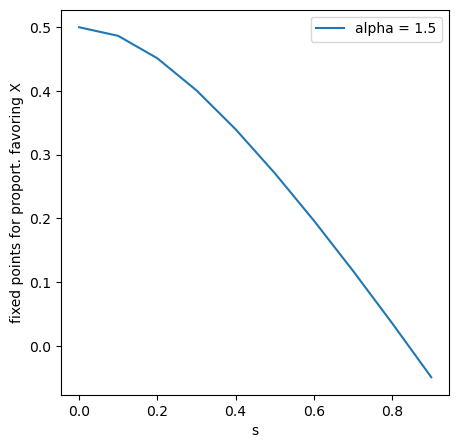

In [ ]:
fig = plt.figure(1, figsize= (5,5))
#plt.plot('xlabel', 'ylabel')#, data='a')

plt.plot(solutions_svar[:, 0], x, '-', label='alpha = 1.5')
#plt.plot(x, f_a1, '--', label='alpha = 1')
#plt.plot(x, f_a05, '-', label='alpha = 0.5')  
plt.xlabel("s")
plt.ylabel("fixed points for proport. favoring X")
plt.legend()

In [ ]:
x

0.183940781976591